In [3]:
import os, json
from typing import List, Tuple, Optional

import numpy as np
import polars as pl
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_score
from tqdm import tqdm
from loguru import logger

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from pathlib import Path

MODEL_DIR = Path.cwd() / 'models'

In [4]:
# ----------------------------
# Data utilities
# ----------------------------
class MultiLabelDataset(Dataset):
    def __init__(
        self,
        df: pl.DataFrame,
        tokenizer,
        n_labels: int,
        max_len: int = 512,
        chunk_size: Optional[int] = None,
        chunk_stride: Optional[int] = None
    ):
        self.texts = df["text"].to_list()
        self.labels_list = df["topic_label"].to_list()
        self.n_labels = n_labels
        self.tok = tokenizer
        self.max_len = max_len

        # chunking: precompute (doc_idx, chunk_idx) index if chunking enabled
        self.use_chunking = bool(chunk_size) and chunk_size > 0
        self.chunk_size = chunk_size if self.use_chunking else None
        self.chunk_stride = max(0, chunk_stride) if (self.use_chunking and chunk_stride is not None) else 0
        if self.use_chunking:
            self.doc_chunks = []   # list of dicts returned by tokenizer per doc
            self.index = []        # list of (doc_idx, chunk_idx)
            for di, t in enumerate(self.texts):
                enc = self.tok(
                    t,
                    truncation=True,
                    max_length=self.chunk_size,
                    stride=self.chunk_stride,
                    return_overflowing_tokens=True,
                    padding=False,
                )
                n = len(enc["input_ids"])
                self.doc_chunks.append(enc)
                for ci in range(n):
                    self.index.append((di, ci))

        logger.info(f"Initialized MultiLabelDataset (chunking={self.use_chunking})")

    def __len__(self):
        # NEW (chunking): number of chunks vs. number of docs
        return len(self.index) if self.use_chunking else len(self.texts)

    def __getitem__(self, i):
        if self.use_chunking:
            di, ci = self.index[i]
            encs = self.doc_chunks[di]
            input_ids = encs["input_ids"][ci]
            attention_mask = encs["attention_mask"][ci]
            y = torch.zeros(self.n_labels, dtype=torch.float)
            for lab in self.labels_list[di]:
                if 0 <= lab < self.n_labels:
                    y[lab] = 1.0
            # include doc_index for later aggregation
            return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": y, "doc_index": di}
        else:
            enc = self.tok(self.texts[i], truncation=True, padding=False, max_length=self.max_len)
            y = torch.zeros(self.n_labels, dtype=torch.float)
            for lab in self.labels_list[i]:
                if 0 <= lab < self.n_labels:
                    y[lab] = 1.0
            return {**enc, "labels": y}


def collate_pad(batch, pad_id: int):
    keys = ["input_ids", "attention_mask"]
    max_len = max(len(b["input_ids"]) for b in batch)
    for b in batch:
        for k in keys:
            pad_len = max_len - len(b[k])
            if pad_len > 0:
                b[k] = b[k] + ([pad_id] * pad_len)
    input_ids = torch.tensor([b["input_ids"] for b in batch], dtype=torch.long)
    attn = torch.tensor([b["attention_mask"] for b in batch], dtype=torch.long)
    labels = torch.stack([b["labels"] for b in batch])
    out = {"input_ids": input_ids, "attention_mask": attn, "labels": labels}

    # NEW (chunking): pass through doc_index if present
    if "doc_index" in batch[0]:
        out["doc_index"] = torch.tensor([b["doc_index"] for b in batch], dtype=torch.long)
    return out


# ----------------------------
# Imbalance helpers (unchanged)
# ----------------------------
def compute_label_stats(labels_list: List[List[int]], n_labels: int) -> Tuple[np.ndarray, np.ndarray]:
    counts = np.zeros(n_labels, dtype=np.int64)
    for labs in labels_list:
        for l in labs:
            if 0 <= l < n_labels:
                counts[l] += 1
    N = len(labels_list)
    prevalence = np.clip(counts / max(N, 1), 1e-8, 1 - 1e-8)
    return counts, prevalence

def make_pos_weights(prevalence: np.ndarray, alpha: float = 0.75, max_w: float = 30.0) -> torch.Tensor:
    w = ((1.0 - prevalence) / prevalence) ** alpha
    w = np.clip(w, 1.0, max_w)
    return torch.tensor(w, dtype=torch.float)

def make_doc_weights(labels_list: List[List[int]], label_weights: np.ndarray, pow_m: float = 0.5) -> np.ndarray:
    n = len(labels_list)
    doc_w = np.zeros(n, dtype=np.float32)
    for i, labs in enumerate(labels_list):
        if len(labs) == 0:
            doc_w[i] = 1.0
        else:
            lw = [label_weights[l] for l in labs if 0 <= l < len(label_weights)]
            doc_w[i] = max(lw) if lw else 1.0
    doc_w = np.power(doc_w, pow_m)
    doc_w = doc_w / max(doc_w.mean(), 1e-6)
    return doc_w


# ----------------------------
# Model (unchanged)
# ----------------------------
class MultiLabelHead(nn.Module):
    def __init__(self, backbone_name: str, n_labels: int, dropout: float = 0.2, use_mean_pool: bool = False):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(backbone_name)
        self.hidden = self.backbone.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden, n_labels)
        self.use_mean_pool = use_mean_pool

    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        token_emb = out.last_hidden_state if hasattr(out, "last_hidden_state") else out[0]
        if self.use_mean_pool:
            mask = attention_mask.unsqueeze(-1).float()
            x = (token_emb * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1e-6)
        else:
            x = token_emb[:, 0]  # CLS
        logits = self.classifier(self.dropout(x))
        return logits


# ----------------------------
# Optional loss & threshold tuning (unchanged)
# ----------------------------
class ASLBCE(nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=4.0, clip=0.05, reduction="mean"):
        super().__init__()
        self.gp = gamma_pos
        self.gn = gamma_neg
        self.clip = clip
        self.reduction = reduction

    def forward(self, logits, targets):
        x = torch.sigmoid(logits)
        if self.clip and self.clip > 0:
            x = torch.clamp(x - self.clip, min=0.0, max=1.0)
        xs_pos = x
        xs_neg = 1.0 - x
        lossp = - targets * torch.pow(1 - xs_pos, self.gp) * torch.log(xs_pos.clamp_min(1e-8))
        lossn = - (1 - targets) * torch.pow(1 - xs_neg, self.gn) * torch.log(xs_neg.clamp_min(1e-8))
        loss = lossp + lossn
        return loss.mean() if self.reduction == "mean" else (loss.sum() if self.reduction == "sum" else loss)

def tune_thresholds_with_precision(
    probs: np.ndarray,
    y_true: np.ndarray,
    grid: Optional[np.ndarray] = None,
    precision_floor: Optional[np.ndarray] = None
) -> np.ndarray:
    N, L = probs.shape
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    th = np.zeros(L, dtype=np.float32)
    for l in range(L):
        y = y_true[:, l]; p = probs[:, l]
        best_f1, best_t = -1.0, 0.5
        for t in grid:
            pred = (p >= t).astype(int)
            if precision_floor is not None:
                prec = precision_score(y, pred, zero_division=0)
                if prec < precision_floor[l]:
                    continue
            f1 = 1.0 if (y.sum()==0 and pred.sum()==0) else f1_score(y, pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        th[l] = best_t
    return th


# ----------------------------
# Aggregation helper
# ----------------------------
def _aggregate_doc_probs(per_doc_probs: List[List[np.ndarray]],
                         per_doc_true: List[List[np.ndarray]],
                         agg: str = "max") -> Tuple[np.ndarray, np.ndarray]:
    agg_fn = np.max if agg == "max" else np.mean
    probs_doc = np.stack([agg_fn(np.stack(pp, axis=0), axis=0) if len(pp)>0 else np.zeros_like(per_doc_true[0][0])
                          for pp in per_doc_probs])
    true_doc  = np.stack([tt[0] if len(tt)>0 else np.zeros_like(per_doc_true[0][0]) for tt in per_doc_true])
    return probs_doc, true_doc


# ----------------------------
# Eval helper
# ----------------------------
@torch.no_grad()
def evaluate(model, loader, device, logit_adjust=None, *, aggregate: Optional[str] = None, n_docs: Optional[int] = None):
    """
    If aggregate is None: returns stacked chunk-level (or doc-level) probs/true like before.
    If aggregate in {"max","mean"} and n_docs is provided: aggregates chunk predictions per original document.
    """
    model.eval()

    # Chunked document-level path
    if aggregate is not None:
        assert n_docs is not None, "n_docs required when using aggregation"
        per_doc_probs: List[List[np.ndarray]] = [[] for _ in range(n_docs)]
        per_doc_true:  List[List[np.ndarray]] = [[] for _ in range(n_docs)]

        for batch in loader:
            ids = batch["input_ids"].to(device)
            att = batch["attention_mask"].to(device)
            y   = batch["labels"].cpu().numpy()
            logits = model(ids, att)
            if logit_adjust is not None:
                logits = logits - logit_adjust
            probs = torch.sigmoid(logits).cpu().numpy()

            doc_idx = batch.get("doc_index", None)
            if doc_idx is None:
                raise ValueError("Aggregation requested but no doc_index found in batch.")
            doc_idx = doc_idx.cpu().numpy().tolist()

            for p, t, di in zip(probs, y, doc_idx):
                per_doc_probs[di].append(p)
                per_doc_true[di].append(t)

        return _aggregate_doc_probs(per_doc_probs, per_doc_true, agg=aggregate)

    # Original (non-aggregated) path
    all_probs, all_true = [], []
    for batch in loader:
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        y   = batch["labels"].cpu().numpy()
        logits = model(ids, att)
        if logit_adjust is not None:
            logits = logits - logit_adjust
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_true.append(y)
    return np.vstack(all_probs), np.vstack(all_true)


# ----------------------------
# Training (plain method call; prevalence/weighting selectable)
# ----------------------------
def train(
    train_df: pl.DataFrame,
    val_df: pl.DataFrame,
    test_df: pl.DataFrame,
    *,
    out_dir: str = MODEL_DIR / "supervise_finetune_model",
    backbone: str = "xlm-roberta-base",
    n_labels: int = 110,
    max_len: int = 512,
    batch_size: int = 16,
    epochs: int = 4,
    lr: float = 2e-5,
    weight_decay: float = 0.01,
    warmup_frac: float = 0.06,
    dropout: float = 0.2,
    mean_pool: bool = False,
    device: Optional[str] = None,
    # ---- Imbalance / prevalence toggles ----
    use_prevalence: bool = True,
    use_pos_weight: bool = True,
    use_weighted_sampler: bool = True,
    pos_alpha: float = 0.75,
    pos_maxw: float = 30.0,
    sampler_pow: float = 0.5,
    # ---- Logit adjustment & thresholds ----
    use_logit_adjust: bool = False,
    adjust_in_eval_only: bool = True,
    precision_floor_base: float = 0.0,
    # ---- Loss choice ----
    use_asl: bool = False, asl_gpos: float = 0.0, asl_gneg: float = 4.0, asl_clip: float = 0.05,
    # ---- Chunking toggles ----
    use_chunking: bool = False,
    chunk_size: int = 512,
    chunk_stride: int = 64,
    agg: str = "max",  # "max" or "mean"
):
    """
    Returns: dict with keys: best_ckpt_path, thresholds_path, prevalence_path (optional), metrics
    """
    logger.info("Starting training run")
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    assert {"text", "topic_label"}.issubset(train_df.columns), "DataFrames must have columns: text, topic_label"

    # ---- Prevalence ----
    need_prev = use_prevalence and (use_pos_weight or use_weighted_sampler or use_logit_adjust or precision_floor_base > 0.0)
    train_labels = train_df["topic_label"].to_list()
    prevalence = None
    if need_prev:
        _, prevalence = compute_label_stats(train_labels, n_labels)

    # ---- Tokenizer & datasets ----
    tok = AutoTokenizer.from_pretrained(backbone)

    # Use chunked datasets if requested
    train_ds = MultiLabelDataset(
        train_df, tok, n_labels=n_labels,
        max_len=max_len,
        chunk_size=(chunk_size if use_chunking else None),
        chunk_stride=(chunk_stride if use_chunking else None),
    )
    val_ds = MultiLabelDataset(
        val_df, tok, n_labels=n_labels,
        max_len=max_len,
        chunk_size=(chunk_size if use_chunking else None),
        chunk_stride=(chunk_stride if use_chunking else None),
    )
    test_ds = MultiLabelDataset(
        test_df, tok, n_labels=n_labels,
        max_len=max_len,
        chunk_size=(chunk_size if use_chunking else None),
        chunk_stride=(chunk_stride if use_chunking else None),
    )

    # ---- Sampler / loaders ----
    if use_weighted_sampler and prevalence is not None:
        label_w = (1.0 - prevalence) / prevalence
        doc_w = make_doc_weights(train_labels, label_w, pow_m=sampler_pow)

        # NEW (chunking): sample weights at the *sample* level if chunking
        if getattr(train_ds, "use_chunking", False):
            sample_w = [float(doc_w[di]) for (di, _ci) in train_ds.index]
            weights = torch.tensor(sample_w, dtype=torch.double)
            num_samples = len(train_ds)
        else:
            weights = torch.tensor(doc_w, dtype=torch.double)
            num_samples = len(train_ds)

        sampler = WeightedRandomSampler(weights=weights, num_samples=num_samples, replacement=True)
        shuffle_train = False
    else:
        sampler = None
        shuffle_train = True

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, sampler=sampler, shuffle=shuffle_train,
        collate_fn=lambda b: collate_pad(b, tok.pad_token_id)
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: collate_pad(b, tok.pad_token_id)
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: collate_pad(b, tok.pad_token_id)
    )

    # ---- Model, loss, optim, sched ----
    model = MultiLabelHead(backbone, n_labels=n_labels, dropout=dropout, use_mean_pool=mean_pool).to(device)

    if use_asl:
        criterion = ASLBCE(gamma_pos=asl_gpos, gamma_neg=asl_gneg, clip=asl_clip)
        pos_w_t = None
    else:
        if use_pos_weight and prevalence is not None:
            pos_w_t = make_pos_weights(prevalence, alpha=pos_alpha, max_w=pos_maxw).to(device)
        else:
            pos_w_t = None
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w_t)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * max(epochs, 1)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(warmup_frac * total_steps),
        num_training_steps=total_steps
    )

    # ---- Optional logit adjustment vector ----
    logit_adjust_vec = None
    if use_logit_adjust and prevalence is not None:
        la = np.log(prevalence / (1.0 - prevalence))
        logit_adjust_vec = torch.tensor(la, dtype=torch.float, device=device)

    best_micro = -1.0
    best_ckpt = os.path.join(out_dir, "best_model.pt")

    # ---- Train loop ----
    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {ep}", leave=False):
            ids = batch["input_ids"].to(device)
            att = batch["attention_mask"].to(device)
            y   = batch["labels"].to(device)

            logits = model(ids, att)
            if logit_adjust_vec is not None and not adjust_in_eval_only:
                logits = logits - logit_adjust_vec

            loss = criterion(logits, y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running += loss.item()

        # ---- Validation ----
        val_probs, val_true = evaluate(
            model, val_loader, device,
            logit_adjust=(logit_adjust_vec if adjust_in_eval_only else None),
            aggregate=(agg if use_chunking else None),      # NEW
            n_docs=(len(val_df) if use_chunking else None)  # NEW
        )

        # Precision floors
        if precision_floor_base > 0.0:
            if prevalence is not None:
                ranks = prevalence.argsort().argsort()
                rarity = 1.0 - (ranks / (n_labels - 1 + 1e-8))
                floors = (precision_floor_base * rarity).clip(0.0, 0.9)
            else:
                floors = np.full(n_labels, precision_floor_base, dtype=np.float32)
        else:
            floors = None

        th = tune_thresholds_with_precision(val_probs, val_true, precision_floor=floors)
        val_pred = (val_probs >= th).astype(int)
        micro = f1_score(val_true, val_pred, average="micro")
        macro = f1_score(val_true, val_pred, average="macro")
        print(f"Epoch {ep}/{epochs} - loss {running/len(train_loader):.4f} | micro-F1 {micro:.4f} | macro-F1 {macro:.4f}")

        if micro > best_micro:
            best_micro = micro
            torch.save(model.state_dict(), best_ckpt)
            np.save(os.path.join(out_dir, "thresholds.npy"), th)
            with open(os.path.join(out_dir, "backbone.json"), "w") as f:
                json.dump({"backbone": backbone}, f)
            if prevalence is not None:
                np.save(os.path.join(out_dir, "prevalence.npy"), prevalence)

    # ---- Test ----
    logger.info("Loading best checkpoint for test...")
    model.load_state_dict(torch.load(best_ckpt, map_location=device))
    th = np.load(os.path.join(out_dir, "thresholds.npy"))
    test_probs, test_true = evaluate(
        model, test_loader, device,
        logit_adjust=(logit_adjust_vec if adjust_in_eval_only else None),
        aggregate=(agg if use_chunking else None),          # NEW
        n_docs=(len(test_df) if use_chunking else None)     # NEW
    )
    test_pred = (test_probs >= th).astype(int)
    micro = f1_score(test_true, test_pred, average="micro")
    macro = f1_score(test_true, test_pred, average="macro")
    logger.info(f"TEST micro-F1 {micro:.4f} | macro-F1 {macro:.4f}")

    prec, rec, f1, support = precision_recall_fscore_support(test_true, test_pred, average=None, zero_division=0)
    per_label = {"precision": prec.tolist(), "recall": rec.tolist(), "f1": f1.tolist(), "support": support.tolist()}
    with open(os.path.join(out_dir, "per_label_metrics.json"), "w") as f:
        json.dump(per_label, f)

    return {
        "best_ckpt_path": best_ckpt,
        "thresholds_path": os.path.join(out_dir, "thresholds.npy"),
        "prevalence_path": (os.path.join(out_dir, "prevalence.npy") if need_prev else None),
        "metrics": {"test_micro_f1": float(micro), "test_macro_f1": float(macro)}
    }


# ----------------------------
# Inference helpers
# ----------------------------
def load_for_inference(out_dir: str, device: Optional[str] = None):
    cfg = json.load(open(os.path.join(out_dir, "backbone.json")))
    backbone = cfg["backbone"]
    th = np.load(os.path.join(out_dir, "thresholds.npy"))
    prev_path = os.path.join(out_dir, "prevalence.npy")
    prevalence = np.load(prev_path) if os.path.exists(prev_path) else None
    tok = AutoTokenizer.from_pretrained(backbone)
    model = MultiLabelHead(backbone, n_labels=len(th))
    dev = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(os.path.join(out_dir, "best_model.pt"), map_location=dev))
    model.to(dev).eval()
    logit_adjust = None
    if prevalence is not None:
        logit_adjust = torch.tensor(np.log(prevalence/(1-prevalence)), dtype=torch.float, device=dev)
    return tok, model, th, logit_adjust, dev

def predict(
    texts,
    out_dir: str,
    device: Optional[str] = None,
    max_len: int = 512,
    label_names: Optional[List[str]] = None,
    top_k: Optional[int] = None,
    apply_logit_adjust: bool = True,
    threshold_override: Optional[np.ndarray] = None,
    # NEW: chunking at inference
    use_chunking: bool = False,
    chunk_size: int = 512,
    chunk_stride: int = 64,
    agg: str = "max",
):
    if isinstance(texts, str):
        texts = [texts]

    tok, model, th, logit_adjust, dev = load_for_inference(out_dir, device=device)
    if threshold_override is not None:
        th = np.asarray(threshold_override, dtype=np.float32)

    outputs = []

    if not use_chunking:
        enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        with torch.no_grad():
            logits = model(enc["input_ids"].to(dev), enc["attention_mask"].to(dev))
            if apply_logit_adjust and logit_adjust is not None:
                logits = logits - logit_adjust
            probs = torch.sigmoid(logits).cpu().numpy()

        preds_bin = (probs >= th).astype(int)
        for i in range(len(texts)):
            on_idx = np.where(preds_bin[i] == 1)[0]
            active = sorted([(j, float(probs[i, j])) for j in on_idx], key=lambda x: x[1], reverse=True)
            sorted_idx = [j for j, _ in active]
            item = {
                "text_index": i,
                "predicted_labels": [label_names[j] if label_names else j for j in sorted_idx],
                "predicted_probs": [float(probs[i, j]) for j in sorted_idx],
                "thresholds_used": [float(th[j]) for j in sorted_idx],
            }
            if top_k is not None:
                order = np.argsort(-probs[i])[:top_k]
                item["top_k"] = [
                    {
                        "label": (label_names[j] if label_names else j),
                        "p": float(probs[i, j]),
                        "t": float(th[j]),
                        "above_threshold": bool(probs[i, j] >= th[j]),
                    } for j in order
                ]
            outputs.append(item)
        return outputs

    # ---- Chunked inference ----
    for i, text in enumerate(texts):
        enc = tok(
            text,
            truncation=True,
            max_length=chunk_size,
            stride=chunk_stride,
            return_overflowing_tokens=True,
            padding=False
        )
        n = len(enc["input_ids"])
        if n == 0:
            # empty fallback
            probs_doc = np.zeros_like(th, dtype=np.float32)
        else:
            # batched over chunks
            ids = torch.tensor(enc["input_ids"], dtype=torch.long, device=dev)
            att = torch.tensor(enc["attention_mask"], dtype=torch.long, device=dev)
            with torch.no_grad():
                logits = model(ids, att)
                if apply_logit_adjust and logit_adjust is not None:
                    logits = logits - logit_adjust
                probs_chunks = torch.sigmoid(logits).cpu().numpy()
            probs_doc = probs_chunks.max(axis=0) if agg == "max" else probs_chunks.mean(axis=0)

        preds_bin = (probs_doc >= th).astype(int)
        on_idx = np.where(preds_bin == 1)[0]
        active = sorted([(j, float(probs_doc[j])) for j in on_idx], key=lambda x: x[1], reverse=True)
        sorted_idx = [j for j, _ in active]
        item = {
            "text_index": i,
            "predicted_labels": [label_names[j] if label_names else j for j in sorted_idx],
            "predicted_probs": [float(probs_doc[j]) for j in sorted_idx],
            "thresholds_used": [float(th[j]) for j in sorted_idx],
        }
        if top_k is not None:
            order = np.argsort(-probs_doc)[:top_k]
            item["top_k"] = [
                {
                    "label": (label_names[j] if label_names else j),
                    "p": float(probs_doc[j]),
                    "t": float(th[j]),
                    "above_threshold": bool(probs_doc[j] >= th[j]),
                } for j in order
            ]
        outputs.append(item)

    return outputs

In [5]:
prototype = True
tr_path = r'data\blogs_articles\train_topics.parquet'
va_path = r'data\blogs_articles\val_topics.parquet'
te_path = r'data\blogs_articles\test_topics.parquet'
train_df = pl.read_parquet(tr_path)
val_df = pl.read_parquet(va_path)
test_df = pl.read_parquet(te_path)

if prototype:
    train_df = train_df.sample(100)
    val_df = val_df.sample(10)
    test_df = test_df.sample(10)

res = train(
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    out_dir = MODEL_DIR / "supervise_finetune_model",
    backbone = "xlm-roberta-base",
    n_labels = 110,
    max_len = 512,
    batch_size = 16,
    epochs = 1,
    lr = 2e-5,
    weight_decay = 0.01,
    warmup_frac = 0.06,
    dropout = 0.2,
    mean_pool = False,
    device = 'cuda',
    use_prevalence = False,          
    use_pos_weight = False,          
    use_weighted_sampler = False,
    pos_alpha = 0.75,
    pos_maxw = 30.0,
    sampler_pow = 0.5,
    use_logit_adjust = False,  
    adjust_in_eval_only = True,
    precision_floor_base = 0.0,
    use_asl= False, 
    asl_gpos = 0.0, 
    asl_gneg = 4.0, 
    asl_clip = 0.05,
    use_chunking =  True,
    chunk_size = 512,
    chunk_stride = 64,
    agg = "max"
    )

2025-09-03 16:49:42.682 | INFO     | __main__:train:298 - Starting training run
2025-09-03 16:49:44.751 | INFO     | __main__:__init__:41 - Initialized MultiLabelDataset (chunking=True)
2025-09-03 16:49:44.837 | INFO     | __main__:__init__:41 - Initialized MultiLabelDataset (chunking=True)
2025-09-03 16:49:44.869 | INFO     | __main__:__init__:41 - Initialized MultiLabelDataset (chunking=True)
c:\Users\povhi\anaconda3\envs\ip\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch 1/1 - loss 0.6191 | micro-F1 0.4267 | macro-F1 0.0973


2025-09-03 16:53:07.058 | INFO     | __main__:train:453 - Loading best checkpoint for test...
c:\Users\povhi\anaconda3\envs\ip\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
2025-09-03 16:53:08.628 | INFO     | __main__:train:465 - TEST micro-F1 0.1102 | macro-F1 0.0224


In [6]:
combined_df = pl.read_parquet(r'data\blogs_articles\combined_parsed_ecb_articles.parquet')
dev_df = combined_df.filter(pl.col('filter_type') == 'topic')
backbone = "xlm-roberta-base"
tok = AutoTokenizer.from_pretrained(backbone)

token_counts = []
for t in tqdm(dev_df["text"].to_list()):
    enc = tok(t, truncation=False, padding=False)
    token_counts.append(len(enc["input_ids"]))

dev_df = dev_df.with_columns(pl.Series("token_count", token_counts))

100%|██████████| 3494/3494 [00:17<00:00, 202.90it/s]


In [13]:
e = tok('''Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec in odio non tellus accumsan eleifend eget eget nisl. Morbi vulputate purus ligula, eu ultricies ante mollis id. Vivamus viverra magna vel orci efficitur volutpat. Maecenas dignissim, elit sit amet volutpat convallis, nunc odio cursus enim, vel maximus mauris risus quis dolor. Curabitur justo dolor, scelerisque sit amet scelerisque nec, vehicula vitae mi. Maecenas tincidunt fermentum rhoncus. Praesent molestie vitae libero eu euismod. In consectetur massa vitae quam euismod blandit sit amet ut nisl. Cras sed nisi at elit lobortis faucibus. Ut ac erat non orci sodales auctor non sed ipsum.
Nunc et magna et sapien tempus placerat. In convallis vitae enim in rhoncus. Vivamus urna dolor, euismod nec libero non, finibus feugiat leo. Morbi tristique velit libero. Etiam sodales varius nunc vel imperdiet. Fusce eget metus consectetur, convallis purus sed, rhoncus sapien. Maecenas mollis, leo quis tristique lobortis, justo elit ornare neque, a lacinia leo mauris eu purus. Mauris semper consequat elit quis interdum. Curabitur tellus neque, porta vel mi id, placerat tempus augue. Curabitur diam dui, dignissim in rutrum in, elementum quis sapien. Mauris dignissim mattis justo non tempor. Sed nibh ipsum, consectetur dignissim efficitur non, pharetra sed felis. Suspendisse consectetur non quam vitae maximus. Duis scelerisque lacinia nisl et pellentesque.
Maecenas ligula turpis, aliquam non eros at, pharetra lobortis velit. Curabitur ut aliquet nulla, in ultricies est. Vivamus vehicula est non lectus laoreet, quis feugiat risus tincidunt. Vestibulum nec augue nunc. Phasellus condimentum turpis fermentum faucibus laoreet. Nunc vestibulum sapien vitae ipsum laoreet pulvinar. Suspendisse ac elit ex. Sed porttitor massa at varius aliquam. Duis mollis est nibh, sit amet tempus leo blandit in. Etiam egestas tellus non consectetur pretium. Nulla risus massa, blandit ac elementum quis, vehicula a dui. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Nunc odio metus, molestie et nisi ac, tincidunt mollis libero.
Pellentesque sed quam commodo, pretium sem ac, pharetra mauris. Sed eget ornare orci, eget finibus velit. In feugiat dui vitae laoreet suscipit. Etiam eu mollis tellus. Nam nisi massa, molestie in neque quis, sodales auctor purus. Donec eleifend nulla non enim lacinia, sit amet suscipit nunc facilisis. Sed ut ex non eros sagittis blandit non posuere eros. Sed accumsan hendrerit purus.
Quisque diam lorem, fringilla vel nibh dictum, ornare bibendum nisl. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec congue risus nec magna lacinia vehicula. Donec cursus nisi neque, eget eleifend ante maximus vel. Sed in vulputate lectus. Donec ante justo, dictum a dui eu, fermentum scelerisque nulla. Nullam fringilla justo vitae ultricies aliquam. Duis semper dapibus nisi a eleifend. Praesent convallis velit velit, ac tincidunt ante consequat et. Duis hendrerit tristique viverra. Quisque et nisi vel ipsum laoreet mattis vel et quam.
Cras ornare, purus placerat suscipit vulputate, urna libero convallis quam, non pulvinar orci enim ac erat. Vivamus tincidunt lobortis felis at aliquam. Maecenas lobortis nisi ut metus commodo, nec egestas neque rutrum. Pellentesque venenatis egestas ullamcorper. Donec eget elementum dui, eu lobortis diam. Phasellus arcu velit, porttitor sed neque non, finibus aliquet lorem. Proin in mattis nisi. Pellentesque sagittis nec risus eu posuere. Ut dapibus eros id consequat aliquet. Mauris a sollicitudin mi. Donec elementum dolor vel sapien accumsan, eget aliquet diam hendrerit. Etiam dictum sit amet erat in lacinia. Pellentesque convallis arcu in nibh facilisis efficitur. Nullam interdum lectus sapien, ac luctus lacus laoreet nec. Etiam sit amet aliquet lorem.
Morbi bibendum eros ac tortor ornare pulvinar. Sed maximus odio nec accumsan consequat. Pellentesque sit amet justo finibus, congue ipsum tempor, mollis magna. Praesent interdum iaculis mi eget pretium. Proin consequat.
''', 
truncation=True,
max_length=512,
stride=64,
return_overflowing_tokens=True,
padding=False,)
e['attention_mask'][1]
len(e["input_ids"])


2

Mean:  1599.0446479679451
Median:  782.0
Std:  2054.6380499911634
Max:  17957
Min:  2


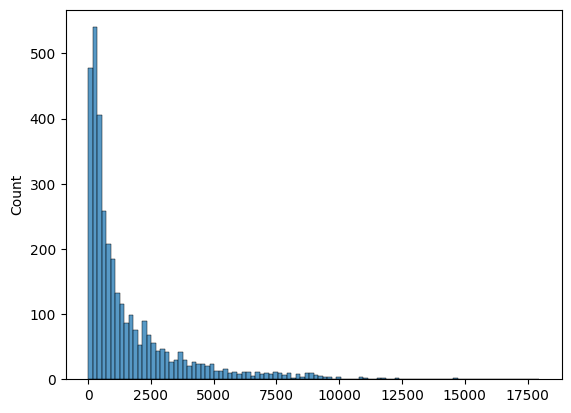

In [17]:
import seaborn as sns

sns.histplot(dev_df['token_count'], bins=100)


print('Mean: ', dev_df['token_count'].mean())
print('Median: ', dev_df['token_count'].median())
print('Std: ', dev_df['token_count'].std())
print('Max: ', dev_df['token_count'].max())
print('Min: ', dev_df['token_count'].min())

In [14]:
dev_df

date,category,title,filter_type,url,filter_value,url_hash,html_downloaded,download_error,index,path_to_html,text,error,authors,suffix,filename,category_base,token_count
date,str,str,str,str,list[str],u64,bool,str,u64,str,str,str,list[str],str,str,str,i64
1997-04-25,"""Press release""","""""EUR"" - the new currency code …","""topic""","""https://www.ecb.europa.eu/pres…","[""Central banking""]",5829553839912007035,true,null,0,"""data\blogs_articles\topics_htm…","""The European Monetary Institut…",null,null,"""html""","""pr970425.en.html""","""Press release""",154
1997-07-01,"""Press release""","""Change of presidency of the Eu…","""topic""","""https://www.ecb.europa.eu/pres…","[""Central banking""]",8460861082098867773,true,null,1,"""data\blogs_articles\topics_htm…","""Dr. Willem Frederik Duisenberg…",null,null,"""html""","""pr970701.en.html""","""Press release""",84
1997-07-02,"""Press release""","""Selection and further developm…","""topic""","""https://www.ecb.europa.eu/pres…","[""Central banking""]",14802581173913312225,true,null,2,"""data\blogs_articles\topics_htm…","""1. SUMMARY The procedure to s…",null,null,"""html""","""pr970702_1.en.html""","""Press release""",1863
1997-07-02,"""Press release""","""The EMI's mandate with respect…","""topic""","""https://www.ecb.europa.eu/pres…","[""Central banking""]",12627879612532599931,true,null,3,"""data\blogs_articles\topics_htm…","""Under Article 105a of the Trea…",null,null,"""html""","""pr970702.en.html""","""Press release""",571
1997-07-02,"""Press release""","""The euro banknotes and the par…","""topic""","""https://www.ecb.europa.eu/pres…","[""Central banking""]",16592026379229046180,true,null,4,"""data\blogs_articles\topics_htm…","""The EMI considers that it is i…",null,null,"""html""","""pr970702_2.en.html""","""Press release""",652
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-07-31,"""The ECB Blog""","""The ripple effects of monetary…","""topic""","""https://www.ecb.europa.eu/pres…","[""Interest rates"", ""Inflation"", ""Monetary policy""]",7248151552685699297,true,null,4780,"""data\blogs_articles\topics_htm…","""Monetary policy has an impact …",null,"[""Niccolò Battistini"", ""Johannes Gareis""]","""html""","""ecb.blog20250731~f305d1d4cb.en…","""The ECB Blog""",1507
2025-08-04,"""Economic Bulletin - Article""","""Cash is alive… and somewhat yo…","""topic""","""https://www.ecb.europa.eu/pres…","[""Monetary policy""]",15862934961566771934,true,null,4781,"""data\blogs_articles\topics_htm…","""A central puzzle motivating mo…",null,"[""Rebecca Clipal"", ""Alejandro Zamora-Pérez""]","""html""","""ecb.ebart202505_03~d74cb56069.…","""Economic Bulletin""",6795
2025-08-04,"""The ECB Blog""","""Making euro cash fit for the f…","""topic""","""https://www.ecb.europa.eu/pres…","[""Banknotes and coins"", ""Digitalisation""]",6045187915601745579,true,null,4782,"""data\blogs_articles\topics_htm…","""Digital payments are increasin…",null,"[""Piero Cipollone""]","""html""","""ecb.blog20250804~9d3993abe0.en…","""The ECB Blog""",2600
